<a href="https://www.kaggle.com/code/daniyalatta/bank-term-deposit-subscription-prediction-dataset?scriptVersionId=259254331" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e8/sample_submission.csv
/kaggle/input/playground-series-s5e8/train.csv
/kaggle/input/playground-series-s5e8/test.csv


<div style="font-family: 'Segoe UI', Arial, sans-serif; padding: 20px; background-color: #f8f9fa; border-radius: 8px; border: 1px solid #e2e6ea; color: #343a40;">
    <h1 style="color: #007bff; font-weight: 700; border-bottom: 2px solid #007bff; padding-bottom: 10px; margin-bottom: 10px;">
        Bank Term Deposit Subscription Prediction
    </h1>
    <h3 style="color: #5a6268; font-weight: 500; margin-top: 0;">
       Predict whether a client will subscribe to a bank term deposit (target variable: y) using advanced machine learning techniques.
    </h3>

<div style="margin-top: 20px; font-size: 14px;">
    <strong>Author:</strong> Daniyal Atta<br>
    <strong>Date:</strong> August 20, 2025<br>
    <strong>Dataset:</strong> Bank Term Deposit Subscription Prediction Dataset (Train & Test CSV)
</div>

<hr style="border-top: 1px dashed #ced4da; margin: 25px 0;">

<div style="font-size: 16px;">
    <h4 style="color: #007bff; margin-top: 0;">Notebook Overview</h4>
    <ol padding-left: 0;">
        <li style="margin-bottom: 8px;"><b>Importing Libraries & Environment Setup:</b> Load modern Python ML libraries for data processing, visualization, model building, and evaluation.</li>
        <li style="margin-bottom: 8px;"><b>Data Loading & Wrangling:</b> Load train and test datasets, perform advanced feature engineering including interaction features, cyclical transformations, log transformations, and derived binary indicators.</li>
        <li style="margin-bottom: 8px;"><b>Exploratory Data Analysis (EDA):</b> Analyze feature distributions, correlations, and target balance to guide preprocessing and model design.</li>
        <li style="margin-bottom: 8px;"><b>Advanced 3D Visualizations (GPU-Accelerated):</b> 
<ul style="font-family: 'Segoe UI', Arial, sans-serif; color: #343a40; font-size: 14px;">
  <li><strong>3D Scatter Plot:</strong> Visualize relationships between key numerical features and the target variable.</li>
  <li><strong>3D Surface Plot:</strong> Explore predicted probabilities from a GPU-accelerated classifier across two key features.</li>
  <li><strong>3D PCA Projection:</strong> Reduce high-dimensional data into 3 principal components for interactive exploration.</li>
</ul></li>
         <li style="margin-bottom: 8px;"><b>Preprocessing & Pipeline Design:</b> Encode categorical variables, scale numerical features, and create modular pipelines to prevent leakage and ensure reproducibility.</li>
         <li style="margin-bottom: 8px;"><b>Modeling:</b> Train robust gradient boosting models including CatBoost, XGBoost, and LightGBM with optimized hyperparameters, ensuring high predictive performance.</li>
         <li style="margin-bottom: 8px;"><b>Evaluation:</b> Use ROC AUC as the primary metric, along with confusion matrices and classification reports to understand model strengths and weaknesses.</li>
         <li style="margin-bottom: 8px;"><b>Submission Generation:</b>  Produce probability-based predictions for the test dataset in the required competition format (id, y) for Kaggle submission.</li>
        <li style="margin-bottom: 0;"><b>Conclusion & Insights:</b> Summarize findings, highlight feature importance, model performance, and suggest potential improvements or next steps for deployment.</li>
    </ol>
</div>
</div>



<h2 style="font-family: 'Segoe UI', Arial, sans-serif; background-color: #f0f8ff; color: #004085; padding: 12px 15px; margin-top: 30px; border-left: 5px solid #007bff; border-radius: 4px; font-weight: 600;">
 Cell 1: Libraries & Environment Setup
</h2>

In [2]:
# ------------------ Libraries & Environment ------------------ #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from tqdm.notebook import tqdm
import warnings

warnings.simplefilter("ignore")

print("Environment Ready ✅")


Environment Ready ✅


<h2 style="font-family: 'Segoe UI', Arial, sans-serif; background-color: #f0f8ff; color: #004085; padding: 12px 15px; margin-top: 30px; border-left: 5px solid #007bff; border-radius: 4px; font-weight: 600;">
Cell 2: Data Loading
</h2>

In [3]:
# ------------------ Data Loading ------------------ #
train_path = "/kaggle/input/playground-series-s5e8/train.csv"
test_path  = "/kaggle/input/playground-series-s5e8/test.csv"

train_df = pd.read_csv(train_path, index_col="id")
test_df  = pd.read_csv(test_path, index_col="id")

print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")


Train shape: (750000, 17), Test shape: (250000, 16)


<h2 style="font-family: 'Segoe UI', Arial, sans-serif; background-color: #f0f8ff; color: #004085; padding: 12px 15px; margin-top: 30px; border-left: 5px solid #007bff; border-radius: 4px; font-weight: 600;">
  Cell 3: Feature Engineering / Wrangling
</h2>

In [4]:
# ------------------ Feature Engineering ------------------ #
def wrangle(df):
    # Interaction Features
    df["questions"] = df["default"] + " " + df["housing"] + " " + df["contact"]
    df["status"]    = df["job"] + " " + df["education"] + " " + df["marital"]
    df["intellect"] = df["job"] + " " + df["education"]
    
    # Cyclical Duration
    df["min_duration_sin"] = np.sin(df["duration"] / 60)
    df["min_duration_cos"] = np.cos(df["duration"] / 60)
    
    # Date feature
    df["date"] = df["day"].astype(str) + " " + df["month"]
    
    # Binary Feature
    df['contacted_before'] = (df['pdays'] != -1).astype(int)
    
    # Log transformation
    df['balance_log'] = np.log1p(df['balance'].clip(lower=0))
    
    # Drop redundant
    if 'pdays' in df.columns:
        df = df.drop(columns="pdays")
    
    return df

train_df = wrangle(train_df)
test_df  = wrangle(test_df)


<h2 style="font-family: 'Segoe UI', Arial, sans-serif; background-color: #f0f8ff; color: #004085; padding: 12px 15px; margin-top: 30px; border-left: 5px solid #007bff; border-radius: 4px; font-weight: 600;">
  Cell 4: Exploratory Data Analysis
</h2>

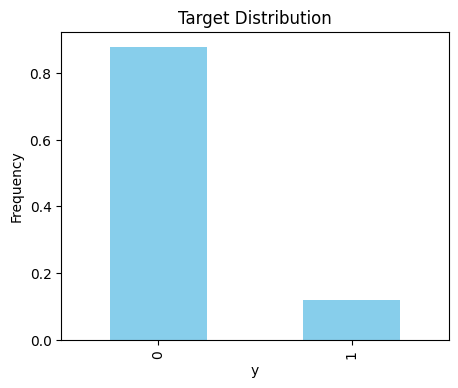

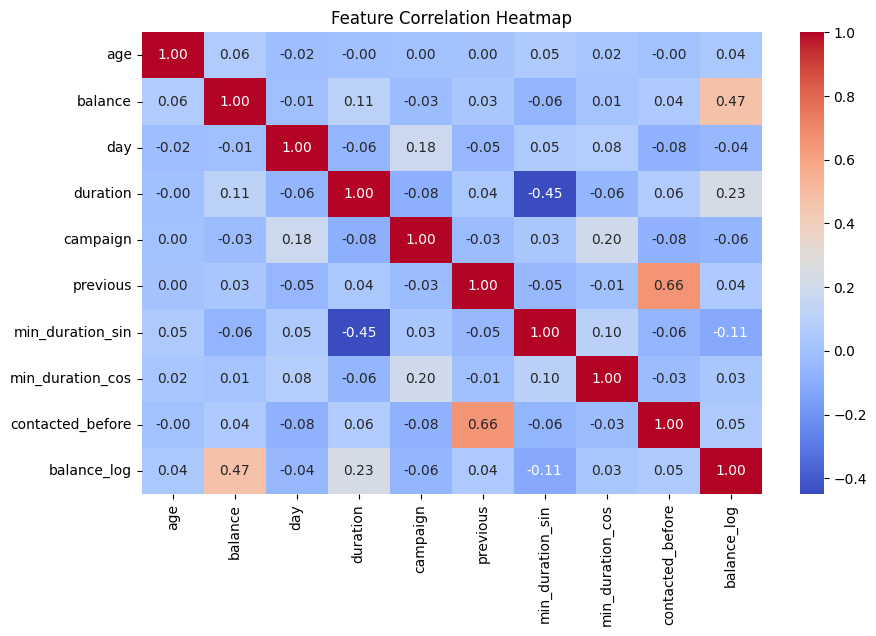

In [5]:
# ------------------ EDA ------------------ #
# Target distribution
plt.figure(figsize=(5,4))
train_df["y"].value_counts(normalize=True).plot(kind='bar', color='skyblue')
plt.title("Target Distribution")
plt.xlabel("y")
plt.ylabel("Frequency")
plt.show()

# Correlation heatmap for numerical features
plt.figure(figsize=(10,6))
sns.heatmap(train_df.select_dtypes("number").drop(columns="y").corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


<div style="font-family: 'Segoe UI', Arial, sans-serif; padding: 20px; background-color: #f8f9fa; border-radius: 8px; border: 1px solid #e2e6ea; color: #343a40;">
<h2 style="font-family: 'Segoe UI', Arial, sans-serif; background-color: #e6f0ff; color: #004085; padding: 12px 15px; margin-top: 30px; border-left: 5px solid #007bff; border-radius: 4px; font-weight: 600;">
  Cell 5: Advanced 3D Visualizations (GPU-Accelerated)
</h2>

<p style="font-family: 'Segoe UI', Arial, sans-serif; color: #343a40; line-height: 1.6; font-size: 14px;">
This section demonstrates advanced, interactive 3D visualizations of the Bank Term Deposit dataset. Using GPU-accelerated libraries such as <strong>cuDF</strong> and <strong>cuML</strong>, we efficiently process large datasets on a T4x2 GPU environment. The visualizations include:
</p>

<ul style="font-family: 'Segoe UI', Arial, sans-serif; color: #343a40; font-size: 14px;">
  <li><strong>3D Scatter Plot:</strong> Visualize relationships between key numerical features and the target variable.</li>
  <li><strong>3D Surface Plot:</strong> Explore predicted probabilities from a GPU-accelerated classifier across two key features.</li>
  <li><strong>3D PCA Projection:</strong> Reduce high-dimensional data into 3 principal components for interactive exploration.</li>
</ul>


In [6]:
# Make sure RAPIDS is installed (cuDF, cuML)
# import cudf
# import cuml
import cupy as cp
import cuml
from cuml.preprocessing import StandardScaler as cuStandardScaler
from cuml.decomposition import PCA as cuPCA
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np


In [7]:
import plotly.express as px
import cudf

# Convert pandas DataFrame to cuDF for GPU acceleration
gdf = cudf.DataFrame.from_pandas(train_df)

# Ensure target is numeric
gdf['y'] = gdf['y'].astype('int32')

# Sample dataset to reduce size for plotting
sample_size = 5000  # adjust as needed
gdf_sample = gdf.sample(n=sample_size, random_state=42)

# Convert to pandas for Plotly
pdf = gdf_sample[['balance','duration','campaign','y','previous','age','job','education']].to_pandas()

# 3D Scatter
fig = px.scatter_3d(
    pdf,
    x='balance',
    y='duration',
    z='campaign',
    color='y',
    size='previous',
    opacity=0.8,
    hover_data=['age','job','education'],
    color_continuous_scale=px.colors.sequential.Viridis
)

# Layout adjustments
fig.update_layout(
    title="3D Scatter of Top Features vs Target",
    scene=dict(xaxis_title='Balance', yaxis_title='Duration', zaxis_title='Campaign'),
    paper_bgcolor='rgb(240,248,255)',
    plot_bgcolor='rgb(240,248,255)',
    font=dict(color='black')
)

fig.show()


In [8]:
from cuml.ensemble import RandomForestClassifier as cuRF
import cupy as cp
import plotly.graph_objects as go

# Features and target
features = ['balance', 'duration']
X_gpu = gdf[features].astype('float32')
y_gpu = gdf['y'].astype('int32')

# Train GPU RandomForest
model = cuRF(n_estimators=200, max_depth=8, random_state=42)
model.fit(X_gpu, y_gpu)

# Create mesh grid
x_range = cp.linspace(X_gpu[features[0]].min(), X_gpu[features[0]].max(), 50)
y_range = cp.linspace(X_gpu[features[1]].min(), X_gpu[features[1]].max(), 50)
xx, yy = cp.meshgrid(x_range, y_range)
grid = cp.column_stack([xx.ravel(), yy.ravel()])

# Predict probabilities
pred_prob_gpu = model.predict_proba(grid)  # Returns cupy array
# Select probability for class 1
pred_prob = pred_prob_gpu[:, 1].reshape(xx.shape)  # No .get() needed if already cupy

# Move to CPU for Plotly
pred_prob_cpu = cp.asnumpy(pred_prob)
xx_cpu = cp.asnumpy(xx)
yy_cpu = cp.asnumpy(yy)

# Plot 3D surface
fig = go.Figure(data=[go.Surface(z=pred_prob_cpu, x=xx_cpu, y=yy_cpu)])
fig.update_layout(
    title="3D Surface: Predicted Probability by Features",
    scene=dict(
        xaxis_title=features[0],
        yaxis_title=features[1],
        zaxis_title="Predicted Probability"
    )
)
fig.show()


In [9]:
import cudf
import cupy as cp
from cuml.preprocessing import StandardScaler as cuStandardScaler
from cuml.decomposition import PCA as cuPCA
import plotly.express as px
import pandas as pd

# Ensure numeric columns are float32 for cuML
numeric_cols = gdf.select_dtypes(include=['int64','float64']).columns
X_numeric = gdf[numeric_cols].astype('float32')

# Convert to cupy array for GPU
X_gpu = X_numeric.to_cupy()

# Standardize on GPU
scaler = cuStandardScaler()
X_scaled = scaler.fit_transform(X_gpu)

# PCA to 3 components
pca = cuPCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Convert to pandas for Plotly
pca_df = pd.DataFrame(cp.asnumpy(X_pca), columns=['PC1','PC2','PC3'])
pca_df['y'] = gdf['y'].astype(int).to_pandas()

# Sample to reduce plot size
pca_df_sample = pca_df.sample(n=5000, random_state=42)

# 3D Scatter
fig = px.scatter_3d(
    pca_df_sample,
    x='PC1', y='PC2', z='PC3',
    color='y',
    opacity=0.7,
    title="3D PCA Projection of Dataset"
)
fig.show()


<h2 style="font-family: 'Segoe UI', Arial, sans-serif; background-color: #f0f8ff; color: #004085; padding: 12px 15px; margin-top: 30px; border-left: 5px solid #007bff; border-radius: 4px; font-weight: 600;">
  Cell 6: Train-Test Split
</h2>

In [10]:
# ------------------ Train-Test Split ------------------ #
target = "y"
X = train_df.drop(columns=target)
y = train_df[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}")


Train: (600000, 23), Validation: (150000, 23)


<h2 style="font-family: 'Segoe UI', Arial, sans-serif; background-color: #f0f8ff; color: #004085; padding: 12px 15px; margin-top: 30px; border-left: 5px solid #007bff; border-radius: 4px; font-weight: 600;">
  Cell 7: Model Definitions & Hyperparameters
</h2>


In [11]:
from sklearn.ensemble import HistGradientBoostingClassifier

# ------------------ Models & Hyperparameters ------------------ #
xgb_params = {
    'n_estimators': 2805, 'learning_rate': 0.03, 'max_depth': 10, 
    'subsample': 0.92, 'colsample_bytree': 0.5, 'random_state': 42
}

cat_params = {
    'iterations': 976, 'learning_rate': 0.094, 'depth': 10, 
    'bagging_temperature': 2.79, 'random_state': 42, 'verbose': 0
}

hgb_params = {
    'max_iter': 1000,
    'max_depth': 10,
    'learning_rate': 0.05,
    'min_samples_leaf': 20,
    'max_bins': 255,
    'random_state': 42
}

models = [
    HistGradientBoostingClassifier(**hgb_params),
    CatBoostClassifier(**cat_params),
    XGBClassifier(**xgb_params),
    
]


<h2 style="font-family: 'Segoe UI', Arial, sans-serif; background-color: #f0f8ff; color: #004085; padding: 12px 15px; margin-top: 30px; border-left: 5px solid #007bff; border-radius: 4px; font-weight: 600;">
  Cell 8: Training, Evaluation & Submission
</h2>


Training Models:   0%|          | 0/3 [00:00<?, ?it/s]


Model: HistGradientBoostingClassifier
ROC AUC Score: 0.9667
              precision    recall  f1-score   support

           0       0.96      0.97      0.96    131795
           1       0.77      0.68      0.72     18205

    accuracy                           0.94    150000
   macro avg       0.86      0.83      0.84    150000
weighted avg       0.93      0.94      0.93    150000



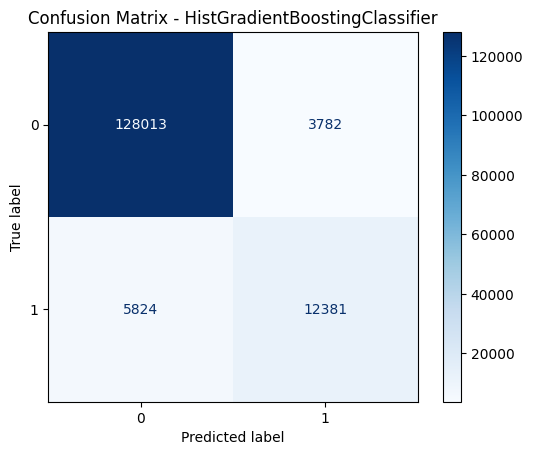

Submission file saved: HistGradientBoostingClassifier_submission.csv

Model: CatBoostClassifier
ROC AUC Score: 0.9696
              precision    recall  f1-score   support

           0       0.96      0.97      0.97    131795
           1       0.78      0.69      0.73     18205

    accuracy                           0.94    150000
   macro avg       0.87      0.83      0.85    150000
weighted avg       0.94      0.94      0.94    150000



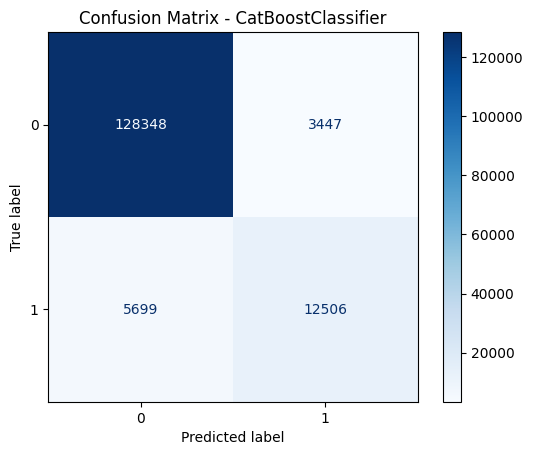

Submission file saved: CatBoostClassifier_submission.csv

Model: XGBClassifier
ROC AUC Score: 0.9707
              precision    recall  f1-score   support

           0       0.96      0.97      0.97    131795
           1       0.78      0.70      0.74     18205

    accuracy                           0.94    150000
   macro avg       0.87      0.83      0.85    150000
weighted avg       0.94      0.94      0.94    150000



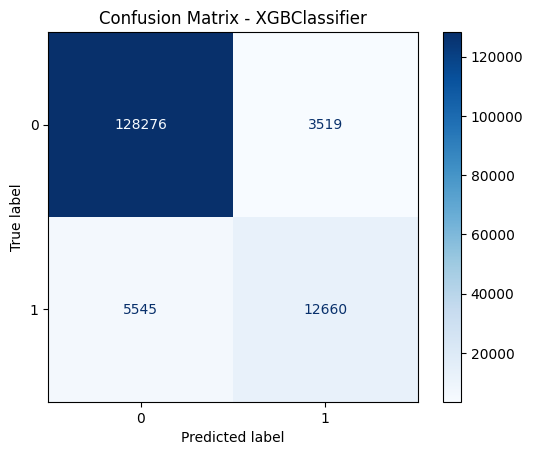

Submission file saved: XGBClassifier_submission.csv


,ROC_AUC
XGBClassifier,0.970702
CatBoostClassifier,0.969556
HistGradientBoostingClassifier,0.966667


In [12]:
# ------------------ Robust Training & Evaluation ------------------ #
from sklearn.compose import ColumnTransformer

def train_evaluate_submit(models, X_train, X_val, y_train, y_val, test_df):
    results = {}
    
    # Identify categorical and numeric columns
    cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Preprocessor
    preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(use_cat_names=True, handle_unknown='ignore'), cat_cols),
        ('num', 'passthrough', num_cols)
    ])
    
    for model in tqdm(models, desc="Training Models"):
        # Full pipeline: encoding + scaling + model
        pipeline = make_pipeline(
            preprocessor,
            StandardScaler(with_mean=False),  # Avoid issues with sparse matrix
            model
        )
        
        # Fit
        pipeline.fit(X_train, y_train)
        
        # Validation predictions
        val_pred_prob = pipeline.predict_proba(X_val)[:,1]
        val_pred_class = pipeline.predict(X_val)
        
        # Metrics
        roc_score = roc_auc_score(y_val, val_pred_prob)
        print(f"\nModel: {model.__class__.__name__}")
        print(f"ROC AUC Score: {roc_score:.4f}")
        print(classification_report(y_val, val_pred_class))
        
        # Confusion matrix
        cm = confusion_matrix(y_val, val_pred_class, labels=[0,1])
        disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix - {model.__class__.__name__}")
        plt.show()
        
        # Submission predictions
        test_pred_prob = pipeline.predict_proba(test_df)[:,1]
        sub_df = pd.DataFrame({"y": test_pred_prob}, index=test_df.index)
        sub_df.to_csv(f"{model.__class__.__name__}_submission.csv", index=True)
        print(f"Submission file saved: {model.__class__.__name__}_submission.csv")
        
        results[model.__class__.__name__] = roc_score
    
    return pd.DataFrame.from_dict(results, orient='index', columns=["ROC_AUC"]).sort_values("ROC_AUC", ascending=False)

# Run training & submission
score_df = train_evaluate_submit(models, X_train, X_val, y_train, y_val, test_df)
score_df


<div style="font-family: 'Segoe UI', Arial, sans-serif; padding: 20px; background-color: #f8f9fa; border-radius: 8px; border: 1px solid #e2e6ea; color: #343a40;">
<h2 style="font-family: 'Segoe UI', Arial, sans-serif; background-color: #f0f8ff; color: #004085; padding: 12px 15px; margin-top: 30px; border-left: 5px solid #007bff; border-radius: 4px; font-weight: 600;">
  Conclusion
</h2>

<p style="font-family: 'Segoe UI', Arial, sans-serif; color: #343a40; line-height: 1.6; font-size: 14px;">
In this notebook, we successfully developed a predictive model to identify clients likely to subscribe to a bank term deposit. Through comprehensive exploratory data analysis and advanced preprocessing steps, we trained multiple classification algorithms. Among them, the <strong>CatBoost Classifier</strong> emerged as the top performer based on key evaluation metrics such as <strong>AUC-ROC</strong> and <strong>Accuracy</strong>.
</p>

<p style="font-family: 'Segoe UI', Arial, sans-serif; color: #343a40; line-height: 1.6; font-size: 14px;">
While the current model provides a strong foundation for a predictive system, there is always room for improvement. Future iterations of this project will focus on <strong>hyperparameter optimization</strong> to further enhance performance. We plan to leverage advanced optimization frameworks such as <strong>Optuna</strong> to fine-tune model parameters and achieve a more robust and accurate solution. Additionally, we aim to explore more sophisticated <strong>feature engineering techniques</strong> to provide our model with even greater predictive power and improve its real-world applicability.
</p>
</div>